# Celltype auto annotation with MetaTiME

MetaTiME learns data-driven, interpretable, and reproducible gene programs by integrating millions of single cells from hundreds of tumor scRNA-seq data. The idea is to learn a map of single-cell space with biologically meaningful directions from large-scale data, which helps understand functional cell states and transfers knowledge to new data analysis. MetaTiME provides pretrained meta-components (MeCs) to automatically annotate fine-grained cell states and plot signature continuum for new single-cells of tumor microenvironment.

Here, we integrate MetaTiME in omicverse. This tutorial demonstrates how to use [MetaTiME (original code)](https://github.com/yi-zhang/MetaTiME/blob/main/docs/notebooks/metatime_annotator.ipynb) to annotate celltype in TME

Paper: [MetaTiME integrates single-cell gene expression to characterize the meta-components of the tumor immune microenvironment](https://www.nature.com/articles/s41467-023-38333-8)

Code: https://github.com/yi-zhang/MetaTiME

Colab_Reproducibility：https://colab.research.google.com/drive/1isvjTfSFM2cy6GzHWAwbuvSjveEJijzP?usp=sharing

![metatime](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41467-023-38333-8/MediaObjects/41467_2023_38333_Fig1_HTML.png)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import omicverse as ov
ov.plot_set(font_path='Arial')
!date

🔬 Starting plot initialization...
Using already downloaded Arial font from: /tmp/omicverse_arial.ttf
Registered as: Arial
🧬 Detecting CUDA devices…
✅ [GPU 0] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5
✅ [GPU 1] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

🔖 Version: 1.7.6rc1   📚 Tutorials: https://omicverse.readthedocs.io/
✅ plot_set complete.

2025年 08月 05日 星期二 13:02:22 CST


## Data normalize and Batch remove

The sample data has multiple patients , and we can use batch correction on patients. Here, we using [scVI](https://docs.scvi-tools.org/en/stable/) to remove batch.

<div class="admonition warning">
  <p class="admonition-title">Note</p>
  <p>
    If your data contains count matrix, we provide a wrapped function for pre-processing the data. Otherwise, if the data is already depth-normalized, log-transformed, and cells are filtered, we can skip this step.
  </p>
</div>

In [3]:
'''
import scvi
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="patient")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
'''

'\nimport scvi\nscvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="patient")\nvae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")\nvae.train()\nadata.obsm["X_scVI"] = vae.get_latent_representation()\n'

Example data can be obtained from figshare: https://figshare.com/ndownloader/files/41440050

In [4]:
import scanpy as sc
adata=sc.read('TiME_adata_scvi.h5ad')
adata

AnnData object with n_obs × n_vars = 40911 × 2000
    obs: 'RNA_snn_res_1', 'assign_ident', 'assign_score', 'nCount_RNA', 'nFeature_RNA', 'orig_ident', 'patient', 'seurat_clusters', 'treatment', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'isTME'
    var: 'Selected', 'vst_mean', 'vst_variable', 'vst_variance', 'vst_variance_expected', 'vst_variance_standardized', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_rank', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    obsm: 'X_scVI'
    varm: 'PCs'
    layers: 'counts'

It is recommended that malignant cells are identified first and removed for best practice in cell state annotation.

In the BCC data, the cluster of malignant cells are identified with `inferCNV`. We can use the pre-saved column 'isTME' to keep Tumor Microenvironment cells.

These are the authors' exact words, but tests have found that the difference in annotation effect is not that great even without removing the malignant cells

But I think this step is not necessary

In [5]:
#adata = adata[adata.obs['isTME']]

## Neighborhood graph calculated

We note that scVI was used earlier to remove the batch effect from the data, so we need to recalculate the neighbourhood map based on what is stored in `adata.obsm['X_scVI']`. Note that if you are not using scVI but using another method to calculate the neighbourhood map, such as `X_pca`, then you need to change `X_scVI` to `X_pca` to complete the calculation

```
#Example
#sc.tl.pca(adata)
#sc.pp.neighbors(adata, use_rep="X_pca")
```

In [6]:
sc.pp.neighbors(adata, use_rep="X_scVI")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:29)


To visualize the PCA’s embeddings, we use the `pymde` package wrapper in omicverse. This is an alternative to UMAP that is GPU-accelerated.

In [7]:
adata.obsm["X_mde"] = ov.utils.mde(adata.obsm["X_scVI"])

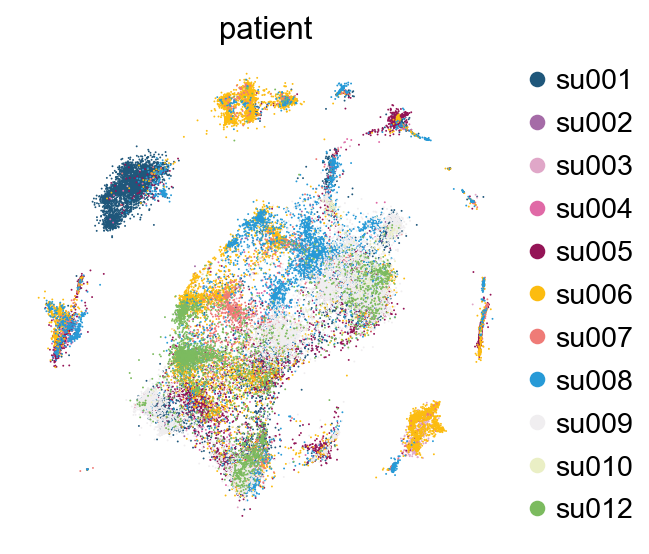

In [8]:
sc.pl.embedding(
    adata,
    basis="X_mde",
    color=["patient"],
    frameon=False,
    ncols=1,
)

In [9]:
#adata.write_h5ad('adata_mde.h5ad',compression='gzip')
#adata=sc.read('adata_mde.h5ad')

## MeteTiME model init

Next, let's load the pre-computed MetaTiME MetaComponents (MeCs), and their functional annotation.

In [11]:
TiME_object=ov.single.MetaTiME(adata,mode='table')

metatime have been install version: 1.3.0
...load pre-trained MeCs
...load functional annotation for MetaTiME-TME


We can over-cluster the cells which is useful for fine-grained cell state annotation.

As the resolution gets larger, the number of clusters gets larger

In [12]:
TiME_object.overcluster(resolution=8,clustercol = 'overcluster',)

...overclustering using leiden
running Leiden clustering
    finished: found 110 clusters and added
    'overcluster', the cluster labels (adata.obs, categorical) (0:00:38)


## TME celltype predicted

We using `TiME_object.predictTiME()` to predicted the latent celltype in TME. 

- The minor celltype will be stored in `adata.obs['MetaTiME']`
- The major celltype will be stored in `adata.obs['Major_MetaTiME']`

In [13]:
TiME_object.predictTiME(save_obs_name='MetaTiME')

...projecting MeC scores
......The predicted celltype have been saved in obs.MetaTiME
......The predicted major celltype have been saved in obs.Major_MetaTiME


AnnData object with n_obs × n_vars = 40911 × 2000
    obs: 'RNA_snn_res_1', 'assign_ident', 'assign_score', 'nCount_RNA', 'nFeature_RNA', 'orig_ident', 'patient', 'seurat_clusters', 'treatment', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'isTME', 'overcluster', 'MetaTiME_overcluster', 'MetaTiME', 'Major_MetaTiME'
    var: 'Selected', 'vst_mean', 'vst_variable', 'vst_variance', 'vst_variance_expected', 'vst_variance_standardized', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_rank', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', 'neighbors', 'patient_colors', 'overcluster', 'REFERENCE_MANU'
    obsm: 'X_scVI', 'X_mde'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

## Visualize

The original author provides a drawing function that effectively avoids overlapping labels. Here I have expanded its parameters so that it can be visualised using parameters other than X_umap

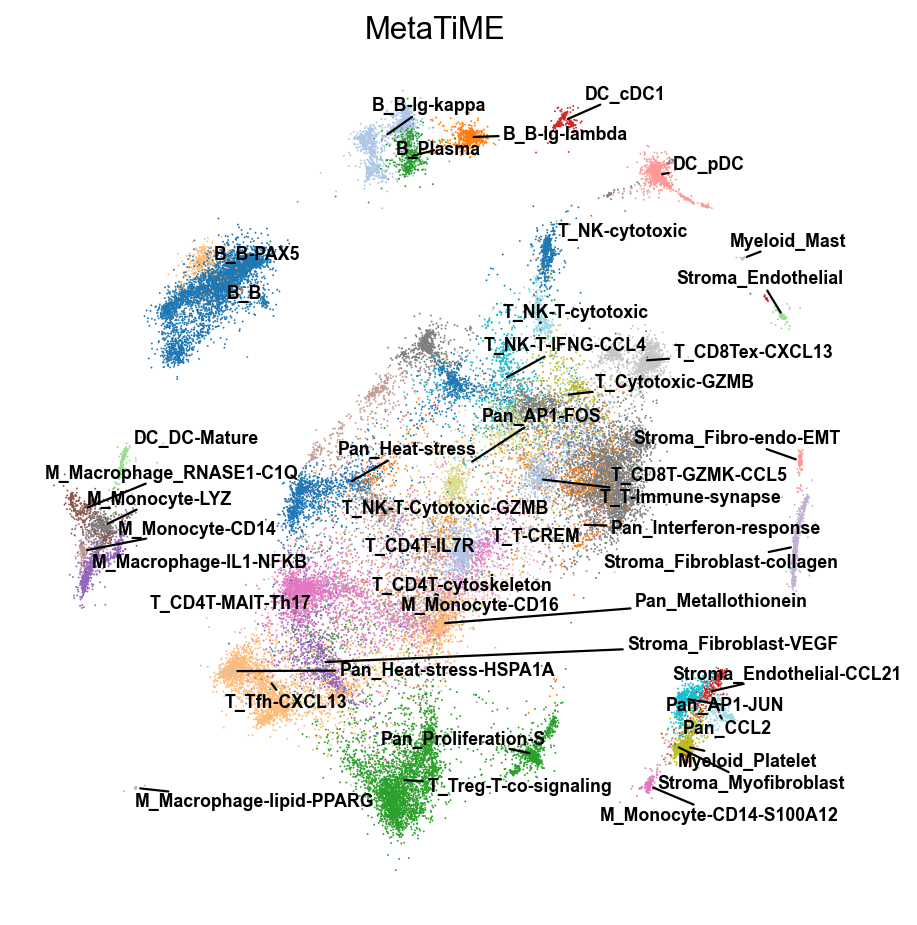

In [14]:
fig,ax=TiME_object.plot(cluster_key='MetaTiME',basis='X_mde',dpi=80)
#fig.save

We can also use `sc.pl.embedding` to visualize the celltype

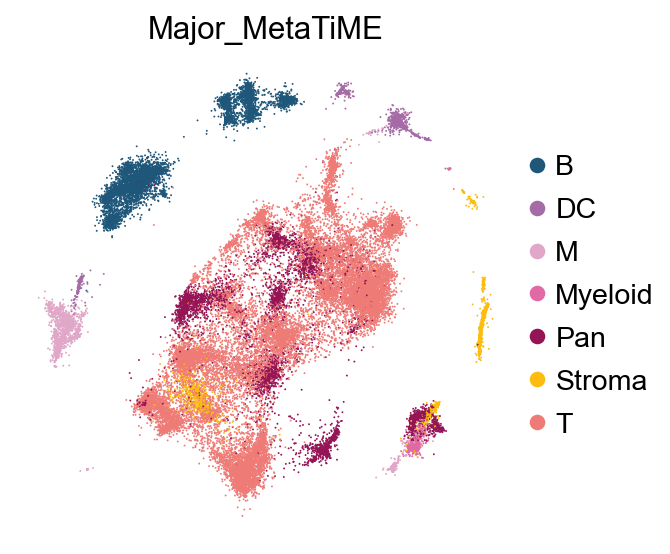

In [15]:
sc.pl.embedding(
    adata,
    basis="X_mde",
    color=["Major_MetaTiME"],
    frameon=False,
    ncols=1,
)